# MARAD Ports and Docks Typology Prototype

## Primary Question: "how do you classify the ports in our nation, based on typology?"

Given a dataset of docks with commodity designations, can we categorize the docks into one of the following typologies?

-	Bulk – Agriculture, Energy, Other
-	Break-Bulk 
-	Roll-on/Roll-off
-	Energy – Bulk, Liquid Bulk, Pipeline
-	Container
-	Cruise/Ferry 
-	Space

## I. Methodology

This problem can be broken down into two main steps, with a long-term crowdsourced validation step:

1. Extracting information from the commodity (and any supplemental) attribute to designate the category of the dock. 

2. Generalizing the dock information up to the Port level using defined logic. 

    - Whether each port receives a single typology is TBD. Approaches including a general typology or a detailed break-down can all be considered. A consideration for Port designation in terms of percentages can be considered an early approach. 

3. Expose a validation app to Port staff to let them review the crosswalk process and confirm the typology is correctly determined.

Provided a dataset of docks from the Army Corps, three approaches are being explored to solve this problem.

### 1. Manual Parsing of Information

Branden Criman and Lori Schroeder parse information from the commodity attribute for each dock to determine values to be passed to new attribute fields corresponding to each typology. 

Pros: 
- Subjective and flexible calls can be made on the assignment for each dock. 
- Leverages domain expertise. 
- Currently the closest approach to a standard operational procedure. 

Cons: 
- Very time-intensive. 
- Subjective calls can be made by different people. 

In [2]:
import arcgis
import getpass
import arcpy
import datetime
import pandas as pd
arcpy.env.overwriteOutput = True

In [3]:
arcgis.gis.GIS().map()

In [4]:
gis_username = getpass.getpass(prompt="Username: ")
gis_pw = getpass.getpass(prompt="Password: ")
gis = arcgis.gis.GIS(r"https://agsbase.dcwebgis.net/portal", gis_username, gis_pw, verify_cert=False)
docks_layer = gis.content.search("MTS_Assets_Docks")[0]
docks_layer

Username: ········
Password: ········


<Item title:"MTS_Assets_Docks" type:Feature Layer Collection owner:alberto>

In [5]:
docks_map = gis.map("United States", zoomlevel=4)
docks_map.add_layer(docks_layer)
docks_map

# 2. Scripted Logic Based on Keyword Terms and Category Assignment ("Data Crosswalk")

In this case, a scripted process would iterate upon each dock record and parse the string data from the 'COMMODITIE' attribute to find designated keywords. 

Keywords would be based on logical connections between commodity terms and typology category. An example of the logical linking of keyword assignments is the term "Petroleum" in connection to the output typology category of "Energy - Bulk, Liquid Bulk, Pipeline".

This methodology would require some effort to pre-designate keyword and category linkages, but would be likely to produce the most similar outputs to the current manual process.

Pros: 
- Specified linkages between terminology and output categories can be predefined. 
- Outputs can be close to what is expected. 
- A straightforward process to document and defend. 

Cons: 
- This procedure would not be flexible if the terminology or schema in the data source changes.

Notes:
- How often does Army Corps change the structure of the data? TBD. It's likely that they don't change very often, but there are definitely cases where changes may be introduced. 
- This mode likely is the backbone to the process, with supplemental checks by the third method. 
- Also needs to be easy to run!

##### Pseudocode

1. Determine typology keyword links - this will be saved in a python dictionary

2. Parse each record of the dataset, and determine typology assignments based on the presence of each keyword

Notes:

- Revisit records from Branden's file to see if a large amount have been removed.
- 240 character limit may result in cut-off terms for keywords
- Some products are in multiple categories - check with Lauren

### Part 1. Docks Typology Processing

In [90]:
# Metadata:

# Date Produced: 1/31
# Participants: Branden Criman, MARAD; Alberto Nieto, Esri
# Unclassified 

tobeclassified_keywords = ["All Manufactured Equipment, Machinery and Products",
                           "Other Non-Metal. Min.",
                           "Unknown or Not Elsewhere Classified"]

remarks_tobeclassified_keywords = [""]

# Liquid bulk
liquid_bulk_keywords = ["Distillate,Residual & Other Fuel Oils; Lube Oil & Greases"]

remarks_liquid_bulk_keywords = []

# Bulk
bulk_keywords = ["Non-Ferrous Ores and Scrap", 
                 "Iron Ore and Iron & Steel Waste & Scrap", 
                 "Sand, Gravel, Stone, Rock, Limestone, Soil, Dredged Material", 
                 "Sulphur (Dry), Clay & Salt",
                 "Fish",
                 "Primary Non-Ferrous Metal Products;Fabricated Metal Prods",
                 "Building Cement & Concrete; Lime; Glass",
                 "Fertilizers",
                 "Other Chemicals and Related Products",
                 "Petroleum Pitches, Coke, Asphalt, Naptha and Solvents",
                 "Coal,Lignite & Coal Coke"]

remarks_bulk_keywords = ["ores"]

# Break-bulk ("Bundled") items
breakbulk_keywords = ["Paper & Allied Products", 
                      "Forest Products, Lumber, Logs, Woodchips", 
                      "Primary Iron and Stee",
                      "Primary Iron and Steel Products (Ingots,Bars,Rods,etc.)"]

remarks_breakbulk_keywords = ["lumber"]

# Roll-on Roll-off
rollon_rolloff_keywords = []

remarks_rollon_rolloff_keywords = []

# Energy
energy_keywords = ["Coal,Lignite & Coal Coke"]

remarks_energy_keywords = ["energy",
                           "petroleum"]

# Container 
container_keywords = []

remarks_container_keywords = ["containers"]

# Cruise
cruise_marina_ferry_keywords = []

remarks_cruise_marina_ferry_keywords = ["ferry", "marina", "cruise"]

# Space
space_keywords = []

remarks_space_keywords = []

We need a dictionary that contains the link between everything: 
- typology types
- typology full designation (code for now, descriptive designation later)
- keywords
    - from commodity
    - from remarks
    - from other fields

In [77]:
# main schema 

input_commodity_field = "COMMODITIE"
input_remarks_field = "REMARKS"
input_construction_field = "CONSTRUCTI"
input_mechanical_field = "MECHANICAL"
input_purpose_field = "PURPOSE"

output_designation_field = "Typology_Designation"  # General typology field name
output_td_bulk_field = "TD_Bulk_Ag_En_Other"
output_td_liquid_bulk_field = "TD_LiquidBulk"
output_td_breakbulk_field = "TD_BreakBulk"
output_td_rollon_rolloff_field = "TD_RollOn_RollOff"
output_td_energy_field = "TD_Energy"
output_td_container_field = "TD_Container"
output_td_cruise_ferry_field = "TD_Cruise_Ferry"
output_td_space_field = "TD_Space"
output_td_tobeclassified_field = "TD_ToBeClassified"

schema_dict = {
    "input_fields": [input_commodity_field,
                     input_remarks_field,
                     input_construction_field,
                     input_mechanical_field,
                     input_purpose_field],
    "output_fields": [output_designation_field,
                      output_td_bulk_field,
                      output_td_liquid_bulk_field,
                      output_td_breakbulk_field,
                      output_td_rollon_rolloff_field,
                      output_td_energy_field,
                      output_td_container_field,
                      output_td_cruise_ferry_field,
                      output_td_space_field,
                      output_td_tobeclassified_field]
}

In [78]:
# TODO Perform schema checks on base docks dataset

base_fieldnames = [field.name for field in arcpy.ListFields(work_docks_fc)]
base_fieldnames

['OBJECTID',
 'Shape',
 'fid',
 'x',
 'y',
 'objectid_1',
 'id',
 'nav_unit_i',
 'unlocode',
 'nav_unit_n',
 'location_d',
 'gateway_ao',
 'port_name',
 'facility_t',
 'street_add',
 'city_or_to',
 'state_post',
 'zipcode',
 'county_nam',
 'county_fip',
 'commoditie',
 'wtwy_name',
 'mile',
 'latitude1',
 'longitude1',
 'operators',
 'owners',
 'dock',
 'constructi',
 'mechanical',
 'remarks',
 'vertical_d',
 'service_in',
 'service_te',
 'bank',
 'location',
 'purpose',
 'stfips',
 'congress',
 'congress_f',
 'depth_min',
 'depth_max',
 'berthing_l',
 'berthing_t',
 'deck_heigh',
 'bulk',
 'energy',
 'break_bulk',
 'other_bulk',
 'units',
 'public_pri',
 'typology_designation',
 'td_bulk_ag_en_other',
 'td_breakbulk',
 'td_rollon_rolloff',
 'td_energy',
 'td_container',
 'td_cruise_ferry',
 'td_space',
 'td_tobeclassified',
 'td_liquidbulk']

In [89]:
# main crosswalk dictionary
# Key: Original typology designations by MARAD
# Values:
# - dictionary of keywords, where each key is a source field (e.g. COMMODITIE)
# - name of output field
crosswalk_dictionary = {
    "Bulk – Agriculture, Energy, Other": {
        "inputs": {
            "commodity_kws": bulk_keywords,
            "remarks_kws": remarks_bulk_keywords
        },
        "outputs": {
            "output_td_field": output_td_bulk_field,
            "output_field_index": 6
        }
    }, 

    "Liquid-Bulk": {
        "inputs": {
            "commodity_kws": liquid_bulk_keywords,
            "remarks_kws": remarks_liquid_bulk_keywords
        },
        "outputs": {
            "output_td_field": output_td_liquid_bulk_field,
            "output_field_index": 7
        }        
    },
    
    "Break-Bulk": {
        "inputs": {
            "commodity_kws": breakbulk_keywords,
            "remarks_kws": remarks_breakbulk_keywords
        },
        "outputs": {
            "output_td_field": output_td_breakbulk_field,
            "output_field_index": 8
        }        
    },    
    
    "Roll-on_Roll-off": {
        "inputs": {
            "commodity_kws": rollon_rolloff_keywords,
            "remarks_kws": remarks_rollon_rolloff_keywords
        },
        "outputs": {
            "output_td_field": output_td_rollon_rolloff_field,
            "output_field_index": 9
        }        
    },        

    "Energy – Bulk, Liquid Bulk, Pipeline": {
        "inputs": {
            "commodity_kws": energy_keywords,
            "remarks_kws": remarks_energy_keywords
        },
        "outputs": {
            "output_td_field": output_td_energy_field,
            "output_field_index": 10
        }        
    },    
    
    "Container": {
        "inputs": {
            "commodity_kws": container_keywords,
            "remarks_kws": remarks_container_keywords
        },
        "outputs": {
            "output_td_field": output_td_container_field,
            "output_field_index": 11
        }        
    },        
    
    "Cruise, Marina, Ferry": {
        "inputs": {
            "commodity_kws": cruise_marina_ferry_keywords,
            "remarks_kws": remarks_cruise_marina_ferry_keywords
        },
        "outputs": {
            "output_td_field": output_td_cruise_ferry_field,
            "output_field_index": 12
        }        
    },        
    
    "Space": {
        "inputs": {
            "commodity_kws": space_keywords,
            "remarks_kws": remarks_space_keywords
        },
        "outputs": {
            "output_td_field": output_td_space_field,
            "output_field_index": 13
        }        
    },
    
    "ToBeClassified": {
        "inputs": {
            "commodity_kws": tobeclassified_keywords,
            "remarks_kws": remarks_tobeclassified_keywords
        },
        "outputs": {
            "output_td_field": output_td_space_field,
            "output_field_index": 14
        }        
    },
}

In [80]:
# Produce copy of baseline docks dataset to work with
work_fgdb = r"D:\ANieto_SolutionEngineer\Projects\DOT\MARAD\MARAD_EBC_180201\MARAD_Pro_Project_EBC\MARAD_Pro_Project_EBC.gdb"
baseline_docks_fc = "{0}\\MTS_Assets_Docks_base".format(work_fgdb)

# Run time timestamp to make output unique
runtime_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


work_docks_fc = arcpy.FeatureClassToFeatureClass_conversion(baseline_docks_fc, 
                                                            work_fgdb, 
                                                            "docks_{0}".format(runtime_timestamp)).getOutput(0)

work_docks_fc

'D:\\ANieto_SolutionEngineer\\Projects\\DOT\\MARAD\\MARAD_EBC_180201\\MARAD_Pro_Project_EBC\\MARAD_Pro_Project_EBC.gdb\\docks_20180205_144540'

In [81]:
# Start iterating on the docks data
with arcpy.da.UpdateCursor(work_docks_fc, 
                           schema_dict["input_fields"] + schema_dict["output_fields"]) as cursor:
    for row in cursor:
        
        # Set reference to row positions for each field
        commodity_val = row[0]
        remarks_val = row[1]
        constuction_val = row[2]
        mechanical_val = row[3]
        purpose_val = row[4]
        
        Typology_Designation = row[5]
        TD_Bulk_Ag_En_Other = row[6]
        TD_LiquidBulk = row[7]
        TD_BreakBulk = row[8]
        TD_RollOn_RollOff = row[9]
        TD_Energy = row[10]
        TD_Container = row[11]
        TD_Cruise_Ferry = row[12]
        TD_Space = row[13]
        TD_ToBeClassified = row[14]
        
        
        # Determine if commodity_val is not null
        if commodity_val is not None and commodity_val not in ["'", " "]:
            
            # Set default output commodity values to false; the checks will overwrite to True if matches are found
            # Note: This is done so that lack of checks do not write False after a True check
            for ix in range(5,15):
                row[ix] = "False"
            
            # Iterate on each typology to check (crosswalk dictionary key)
            for typology_key in crosswalk_dictionary:
                
                # Set reference to the keywords from the commodity and remarks fields
                commodity_keywords = crosswalk_dictionary[typology_key]['inputs']['commodity_kws']
                
                # Iterate on the listing of commodity
                for commodity_keyword in commodity_keywords:
                    
                    # If a match occurs, write it to the designated field
                    if commodity_keyword in commodity_val:
                        row[crosswalk_dictionary[typology_key]['outputs']['output_field_index']] = "True"
                
        # Commit edits to the row
        cursor.updateRow(row)

In [82]:
# # Placeholder - Parser iteration on docks dataset to write output data into category designations using keywork dictionary

# # 1. Key word dictionary, data crosswalk 
# keyword_dictionary = {
#     "Bulk – Agriculture, Energy, Other": bulk_keywords,
#     "Break-Bulk": breakbulk_keywords,
#     "Roll-on/Roll-off": rollon_rolloff_keywords,
#     "Energy – Bulk, Liquid Bulk, Pipeline": energy_keywords,
#     "Container": container_keywords,
#     "Cruise/Marina/Ferry": cruise_marina_ferry_keywords,
#     "Space": space_keywords
# }

# # 2. Source field names
# commodity_field = "COMMODITIE"
# remarks_field = "REMARKS"
# construction_field = "CONSTRUCTI"
# mechanical_field = "MECHANICAL"
# purpose_field = "PURPOSE"

# # 3. Target field names
# designation_field = "Typology_Designation"  # General typology field name

# td_bulk_field = "TD_Bulk_Ag_En_Other"
# td_breakbulk_field = "TD_BreakBulk"
# td_rollon_rolloff_field = "TD_RollOn_RollOff"
# td_energy_field = "TD_Energy"
# td_container_field = "TD_Container"
# td_cruise_ferry_field = "TD_Cruise_Ferry"
# td_space_field = "TD_Space"
# td_tobeclassified_field = "TD_ToBeClassified"

# typology_fields = [commodity_field,
#                    designation_field,
#                    td_bulk_field, 
#                    td_breakbulk_field, 
#                    td_rollon_rolloff_field, 
#                    td_energy_field, 
#                    td_container_field, 
#                    td_cruise_ferry_field,
#                    td_space_field]

# # 4. Iteration and crosswalk processing

# # Start update cursor
# with arcpy.da.UpdateCursor(docks_fc, typology_fields) as cursor:
#     # Iterate on each record
#     counter = 0
#     for row in cursor:
        
#         counter+=1
#         print()
#         print("Commodity: {0}".format(row[0]))
        
#         # If the row has a value
#         if row[0] is not None:
#             # Iterate on each typology word listing in the crosswalk
#             for typology in keyword_dictionary:
#                 # Set reference to the commodity field terms
#                 commodity_terms = keyword_dictionary[typology]

#                 # Iterate on each keyword for the typology, using an enumerator to use the index position of the crosswalk
#                 for ix, term in enumerate(commodity_terms):

#                     # Determine if the commodity field contains any text in the current keyword
#                     if findWordSimple(term, row[0]):
#                         print("\tTerm: {0}".format(term))

#                         # If so, write the typology to the first field in the output typology fields, "designation_field"
#                         print("\tFound match!")
#                         row[1] = typology

#                         # TODO - Write to specific attribute for specific typology

#                         # Update the row
#                         cursor.updateRow(row)
# #         if counter == 5:
# #             break

### Part 2. Ports Typology Processing

#### Pseudocode: 

1. Create a buffer zone around each Port feature

2. Select dock records within buffer zone and determine statistics (total dock count, percentages by typology)

3. Write the typology statistics to output fields in the port table

##### Prepare the Ports dataset

In [83]:
# Produce copy of baseline docks dataset to work with
baseline_ports_fc = "{0}\\Ports_base".format(work_fgdb)

# Run time timestamp to make output unique
runtime_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

work_ports_fc = arcpy.FeatureClassToFeatureClass_conversion(baseline_ports_fc, 
                                                            work_fgdb, 
                                                            "Ports_{0}".format(runtime_timestamp)).getOutput(0)

# Create schema designation for Ports
output_port_fields = ["td_total_docks", 
                      "td_total_bulk",
                      "td_total_liquidbulk",
                      "td_total_breakbulk",
                      "td_total_rollonrolloff",
                      "td_total_energy",
                      "td_total_container",
                      "td_total_cruiseferry",
                      "td_total_space",
                      "td_total_tobeclassified",
                      "td_percentage_bulk",
                      "td_percentage_liquidbulk",
                      "td_percentage_breakbulk",
                      "td_percentage_rollonrolloff",
                      "td_percentage_energy",
                      "td_percentage_container",
                      "td_percentage_cruiseferry",
                      "td_percentage_space",
                      "td_percentage_tobeclassified"]

for field in output_port_fields:
    print("Adding '{0}' field...".format(field))
    arcpy.AddField_management(work_ports_fc, field, field_type="FLOAT")

work_ports_fc

Adding 'td_total_docks' field...
Adding 'td_total_bulk' field...
Adding 'td_total_liquidbulk' field...
Adding 'td_total_breakbulk' field...
Adding 'td_total_rollonrolloff' field...
Adding 'td_total_energy' field...
Adding 'td_total_container' field...
Adding 'td_total_cruiseferry' field...
Adding 'td_total_space' field...
Adding 'td_total_tobeclassified' field...
Adding 'td_percentage_bulk' field...
Adding 'td_percentage_liquidbulk' field...
Adding 'td_percentage_breakbulk' field...
Adding 'td_percentage_rollonrolloff' field...
Adding 'td_percentage_energy' field...
Adding 'td_percentage_container' field...
Adding 'td_percentage_cruiseferry' field...
Adding 'td_percentage_space' field...
Adding 'td_percentage_tobeclassified' field...


'D:\\ANieto_SolutionEngineer\\Projects\\DOT\\MARAD\\MARAD_EBC_180201\\MARAD_Pro_Project_EBC\\MARAD_Pro_Project_EBC.gdb\\Ports_20180205_144543'

In [84]:
# Get the list of fields from the ports data
port_fields = [field.name for field in arcpy.ListFields(work_ports_fc)]
port_fields

['OBJECTID',
 'Shape',
 'ID',
 'PORT_NAME',
 'PORT',
 'TOTAL',
 'DOMESTIC',
 'FOREIGN_',
 'IMPORTS',
 'EXPORTS',
 'td_total_docks',
 'td_total_bulk',
 'td_total_liquidbulk',
 'td_total_breakbulk',
 'td_total_rollonrolloff',
 'td_total_energy',
 'td_total_container',
 'td_total_cruiseferry',
 'td_total_space',
 'td_total_tobeclassified',
 'td_percentage_bulk',
 'td_percentage_liquidbulk',
 'td_percentage_breakbulk',
 'td_percentage_rollonrolloff',
 'td_percentage_energy',
 'td_percentage_container',
 'td_percentage_cruiseferry',
 'td_percentage_space',
 'td_percentage_tobeclassified']

#### Make in_memory layers

In [85]:
# Make an in_memory layer from Ports
ports_lyr = arcpy.MakeFeatureLayer_management(work_ports_fc, "in_memory\ports_layer").getOutput(0)
docks_lyr = arcpy.MakeFeatureLayer_management(work_docks_fc, "in_memory\docks_layer").getOutput(0)

In [86]:
work_docks_df = arcgis.features.SpatialDataFrame.from_featureclass(work_docks_fc)
work_docks_df

OBJECTID     fid           x          y  objectid_1       id nav_unit_i  \
0            1     0.0 -161.940520  64.549158       460.0   1752.0       01Y2   
1            2     1.0 -158.722843  55.235582       472.0   2283.0       02H3   
2            3     2.0 -149.302972  59.904324       688.0     16.0       000P   
3            4     3.0 -146.931103  60.475893       737.0    410.0       00EG   
4            5     4.0 -135.838399  56.740872       826.0    859.0       00VT   
5            6     5.0 -132.401234  55.539151      4901.0   1385.0       01GY   
6            7     6.0 -133.083958  56.552350      4907.0    834.0       00UU   
7            8     7.0 -135.478610  59.286389      1004.0  18738.0       0U9R   
8            9     8.0 -135.465550  59.282778      1005.0  22973.0       0YFF   
9           10     9.0 -135.461110  59.281667      1006.0  18728.0       0U9A   
10          11    10.0 -135.452770  59.280000      1007.0  18727.0       0U99   
11          12    11.0 -135.324440  59.446111      1008.0  18739.0       0U9S   
12          13    12.0 -135.327220  59.450278      1009.0  18741.0       0U9U   
13          14    13.0 -135.324720  59.450278      1010.0  24050.0       0ZH2   
14          15    14.0 -135.323050  59.449167      1011.0  24135.0       0ZKW   
15          16    15.0 -135.323330  59.451389      1012.0  22974.0       0YFG   
16          17    16.0 -135.314097  59.445285      1013.0  18740.0       0U9T   
17          18    17.0 -135.152074  58.856763      1016.0     55.0         25   
18          19    18.0 -135.011857  58.780332      1018.0     54.0         24   
19          20    19.0 -166.237775  68.865686      1022.0   1792.0       01ZH   
20          21    20.0 -164.470769  67.158098      1023.0   2109.0       02BF   
21          22    21.0 -164.541462  67.727297      1024.0   1789.0       01ZE   
22          23    22.0 -162.042898  67.138778      1028.0   2106.0       02BC   
23          24    23.0 -162.042898  67.138778      1029.0   2107.0       02BD   
24          25    24.0 -158.803452  70.849533      1036.0   1799.0       01ZQ   
25          26    25.0 -156.535515  67.851094      1037.0   1782.0       01Z7   
26          27    26.0 -156.469395  67.887807      1039.0   1784.0       01Z9   
27          28    27.0 -156.801577  71.292642      1042.0   1801.0       01ZS   
28          29    28.0 -147.027393  70.153499      1045.0  15115.0       0QMK   
29          30    29.0 -146.345440  70.173815      1046.0  15113.0       0QMH   
...        ...     ...         ...        ...         ...      ...        ...   
7493      7494  9131.0  -80.630940  40.611920     16232.0  13340.0       0N7C   
7494      7495  9132.0  -80.630833  40.613889     16233.0  20768.0       0WA8   
7495      7496  9133.0  -80.626111  40.616111     16234.0  20882.0       0WE4   
7496      7497  9134.0  -80.607778  40.418056     16235.0  20772.0       0WAC   
7497      7498  9135.0  -80.604444  40.418611     16236.0  18834.0       0UD3   
7498      7499  9136.0  -80.604167  40.422778     16237.0  18835.0       0UD4   
7499      7500  9137.0  -80.603111  40.421178     16238.0  15595.0       0RBN   
7500      7501  9138.0  -80.604444  40.427222     16239.0  18836.0       0UD5   
7501      7502  9139.0  -80.607778  40.431389     16240.0  18684.0       0U7Y   
7502      7503  9140.0  -80.553056  40.622222     16251.0  20915.0       0WF8   
7503      7504  9141.0    0.000000   0.000000         0.0      0.0       None   
7504      7505  9142.0    0.000000   0.000000         0.0      0.0       None   
7505      7506  9143.0    0.000000   0.000000         0.0      0.0       None   
7506      7507  9144.0    0.000000   0.000000         0.0      0.0       None   
7507      7508  9145.0    0.000000   0.000000         0.0      0.0       None   
7508      7509  9146.0    0.000000   0.000000         0.0      0.0       None   
7509      7510  9147.0    0.000000   0.000000         0.0      0.0       None   
7510      7511  9148.0    0.000000   

#### Port Processing Main Iteration Loop

In [87]:
# Create a list of Port IDs
port_ids = []
with arcpy.da.SearchCursor(work_ports_fc, ['ID']) as cursor:
    for row in cursor:
        port_ids.append(str(row[0]))
        
port_ids

['122',
 '86',
 '112',
 '113',
 '50',
 '40',
 '107',
 '77',
 '87',
 '24',
 '149',
 '88',
 '129',
 '110',
 '117',
 '36',
 '23',
 '120',
 '9',
 '7',
 '82',
 '118',
 '42',
 '34',
 '58',
 '106',
 '49',
 '136',
 '28',
 '29',
 '124',
 '54',
 '145',
 '66',
 '6',
 '147',
 '71',
 '46',
 '32',
 '51',
 '2',
 '15',
 '19',
 '5',
 '150',
 '12',
 '55',
 '102',
 '133',
 '85',
 '1',
 '8',
 '93',
 '135',
 '91',
 '13',
 '4',
 '114',
 '25',
 '140',
 '146',
 '10',
 '99',
 '109',
 '18',
 '65',
 '27',
 '104',
 '81',
 '35',
 '89',
 '20',
 '31',
 '127',
 '130',
 '76',
 '131',
 '116',
 '45',
 '142',
 '21',
 '138',
 '73',
 '119',
 '90',
 '108',
 '59',
 '38',
 '47',
 '115',
 '64',
 '56',
 '69',
 '14',
 '22',
 '39',
 '78',
 '100',
 '121',
 '134',
 '111',
 '83',
 '79',
 '96',
 '68',
 '139',
 '16',
 '57',
 '97',
 '123',
 '94',
 '144',
 '41',
 '125',
 '84',
 '26',
 '75',
 '95',
 '143',
 '11',
 '17',
 '63',
 '62',
 '43',
 '148',
 '67',
 '103',
 '74',
 '72',
 '80',
 '44',
 '30',
 '105',
 '33',
 '70',
 '92',
 '3',
 '141

In [88]:
# Iterate on each Port ID
dock_to_port_searchradius = "5000 Feet"

# counter = 0
for port_id in port_ids:
#     counter+=1
    print("\nProcessing dock typology statistics for Port ID {0}...".format(port_id))
    
    # Establish where clause
    where_clause = arcpy.AddFieldDelimiters(ports_lyr, "ID") + " = {0}".format(port_id)

    # Make a selection on the Ports Layer to use as the basis for Select-by-Location
    arcpy.SelectLayerByAttribute_management(ports_lyr,
                                            "NEW_SELECTION",
                                            where_clause)
    
    # Make a selection on the Docks layer by location
    arcpy.SelectLayerByLocation_management(docks_lyr, 
                                           "WITHIN_A_DISTANCE", 
                                           ports_lyr, 
                                           dock_to_port_searchradius, 
                                           "NEW_SELECTION")
    
    # Build list of dock IDs 
    port_dock_ids = []
#     dock_counter = 0
    with arcpy.da.SearchCursor(docks_lyr, ["ID"]+schema_dict['output_fields']) as cursor:
        for row in cursor:
#             dock_counter += 1
            port_dock_ids.append(row[0])
    
    #Calculate statistics from DF
    docks_statswork_df = work_docks_df[work_docks_df.id.isin(port_dock_ids)]
    
    total_docks = docks_statswork_df.shape[0]
    
    if total_docks > 0:
    
        total_bulk = docks_statswork_df[work_docks_df.td_bulk_ag_en_other == "True"].shape[0]
        total_liquidbulk = docks_statswork_df[work_docks_df.td_liquidbulk == "True"].shape[0]
        total_breakbulk = docks_statswork_df[work_docks_df.td_breakbulk == "True"].shape[0]
        total_rollonrolloff = docks_statswork_df[work_docks_df.td_rollon_rolloff == "True"].shape[0]
        total_energy = docks_statswork_df[work_docks_df.td_energy == "True"].shape[0]
        total_container = docks_statswork_df[work_docks_df.td_energy == "True"].shape[0]
        total_cruiseferry = docks_statswork_df[work_docks_df.td_cruise_ferry == "True"].shape[0]
        total_space = docks_statswork_df[work_docks_df.td_space == "True"].shape[0]
        total_tobeclassified = docks_statswork_df[work_docks_df.td_tobeclassified == "True"].shape[0]

        perc_bulk = round(total_bulk / total_docks, 2)*100
        perc_liquidbulk = round(total_liquidbulk / total_docks, 2)*100
        perc_breakbulk = round(total_breakbulk / total_docks, 2)*100
        perc_rollonrolloff = round(total_rollonrolloff / total_docks, 2)*100
        perc_energy = round(total_energy / total_docks, 2)*100
        perc_container = round(total_container / total_docks, 2)*100
        perc_cruiseferry = round(total_cruiseferry / total_docks, 2)*100
        perc_space = round(total_space / total_docks, 2)*100
        perc_tobeclassified = round(total_tobeclassified / total_docks, 2)*100
        
    else:
        total_bulk = 0
        total_liquidbulk = 0
        total_breakbulk = 0
        total_rollonrolloff = 0 
        total_energy = 0
        total_container = 0
        total_cruiseferry = 0
        total_space = 0
        total_tobeclassified = 0

        perc_bulk = 0
        perc_liquidbulk = 0
        perc_breakbulk = 0
        perc_rollonrolloff = 0
        perc_energy = 0
        perc_container = 0
        perc_cruiseferry = 0
        perc_space = 0
        perc_tobeclassified = 0       
    
#     break
#     if counter == 2:
#         break

    # Write statistics back to the Port ID
    print("Committing stats to Ports dataset...")
    where_clause = arcpy.AddFieldDelimiters(work_ports_fc, "ID") + " = {0}".format(port_id)
    with arcpy.da.UpdateCursor(work_ports_fc, port_fields, where_clause=where_clause) as cursor:
        for row in cursor:
            row[10] = total_docks
            row[11] = total_bulk
            row[12] = total_liquidbulk
            row[13] = total_breakbulk
            row[14] = total_rollonrolloff
            row[15] = total_energy
            row[16] = total_container
            row[17] = total_cruiseferry
            row[18] = total_space
            row[19] = total_tobeclassified
            row[20] = perc_bulk
            row[21] = perc_liquidbulk
            row[22] = perc_breakbulk
            row[23] = perc_rollonrolloff
            row[24] = perc_energy
            row[25] = perc_container
            row[26] = perc_cruiseferry
            row[27] = perc_space
            row[28] = perc_tobeclassified
            
            cursor.updateRow(row)
    print("Operation complete for port {0}.".format(port_id))
            


Processing dock typology statistics for Port ID 122...
Committing stats to Ports dataset...
Operation complete for port 122.

Processing dock typology statistics for Port ID 86...


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\features\_data\geodataset\geodataframe.py:621: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(SpatialDataFrame, self).__getitem__(key)


Committing stats to Ports dataset...
Operation complete for port 86.

Processing dock typology statistics for Port ID 112...
Committing stats to Ports dataset...
Operation complete for port 112.

Processing dock typology statistics for Port ID 113...
Committing stats to Ports dataset...
Operation complete for port 113.

Processing dock typology statistics for Port ID 50...
Committing stats to Ports dataset...
Operation complete for port 50.

Processing dock typology statistics for Port ID 40...
Committing stats to Ports dataset...
Operation complete for port 40.

Processing dock typology statistics for Port ID 107...
Committing stats to Ports dataset...
Operation complete for port 107.

Processing dock typology statistics for Port ID 77...
Committing stats to Ports dataset...
Operation complete for port 77.

Processing dock typology statistics for Port ID 87...
Committing stats to Ports dataset...
Operation complete for port 87.

Processing dock typology statistics for Port ID 24...
Co

Committing stats to Ports dataset...
Operation complete for port 104.

Processing dock typology statistics for Port ID 81...
Committing stats to Ports dataset...
Operation complete for port 81.

Processing dock typology statistics for Port ID 35...
Committing stats to Ports dataset...
Operation complete for port 35.

Processing dock typology statistics for Port ID 89...
Committing stats to Ports dataset...
Operation complete for port 89.

Processing dock typology statistics for Port ID 20...
Committing stats to Ports dataset...
Operation complete for port 20.

Processing dock typology statistics for Port ID 31...
Committing stats to Ports dataset...
Operation complete for port 31.

Processing dock typology statistics for Port ID 127...
Committing stats to Ports dataset...
Operation complete for port 127.

Processing dock typology statistics for Port ID 130...
Committing stats to Ports dataset...
Operation complete for port 130.

Processing dock typology statistics for Port ID 76...
Com

Committing stats to Ports dataset...
Operation complete for port 33.

Processing dock typology statistics for Port ID 70...
Committing stats to Ports dataset...
Operation complete for port 70.

Processing dock typology statistics for Port ID 92...
Committing stats to Ports dataset...
Operation complete for port 92.

Processing dock typology statistics for Port ID 3...
Committing stats to Ports dataset...
Operation complete for port 3.

Processing dock typology statistics for Port ID 141...
Committing stats to Ports dataset...
Operation complete for port 141.

Processing dock typology statistics for Port ID 101...
Committing stats to Ports dataset...
Operation complete for port 101.

Processing dock typology statistics for Port ID 137...
Committing stats to Ports dataset...
Operation complete for port 137.

Processing dock typology statistics for Port ID 52...
Committing stats to Ports dataset...
Operation complete for port 52.

Processing dock typology statistics for Port ID 61...
Comm

# 3. Clustering of Commodity Semantics

In this case, an exploration of Natural Language Processing (NLP) and clustering of semantic terms is evaluated to find natural patterns in the data with respect to related terms. 

Pros: 
- Would be the most adaptive method to adjust the typology categories based on the input data. 
- Would be able to incorporate new combinations of commodity records to suggest the presence of a new typology category that was not previously encountered. 
- Would be flexible to incorporate additional attributes in the methodology to find patterns that depend on multiple attributes in the dock data.

Cons:
- Would be likely to deviate from the specified typology categories unless some additional constraints are introduced. 
- Much more complex. The logic can be documented but it would be less straightforward to explain and defend. 


Notes:
- Need to make it easy to use.

#### General Data Parsing

In [91]:
import pandas as pd
%matplotlib inline

In [2]:
docks_csv = r"D:\ANieto_SolutionEngineer\Projects\DOT\MARAD\MARAD_EBC_180201\Inputs\MTS_Assets_Docks.csv"

In [3]:
docks_df = pd.read_csv(docks_csv)
docks_df

FID           X          Y  OBJECTID       ID NAV_UNIT_I UNLOCODE  \
0        0 -161.940520  64.549158     460.0   1752.0       01Y2      ELI   
1        1 -158.722843  55.235582     472.0   2283.0       02H3      KPV   
2        2 -149.302972  59.904324     688.0     16.0       000P      SWD   
3        3 -146.931103  60.475893     737.0    410.0       00EG      TEK   
4        4 -135.838399  56.740872     826.0    859.0       00VT      SIT   
5        5 -132.401234  55.539151    4901.0   1385.0       01GY      KTB   
6        6 -133.083958  56.552350    4907.0    834.0       00UU      PSG   
7        7 -135.478610  59.286389    1004.0  18738.0       0U9R      HNS   
8        8 -135.465550  59.282778    1005.0  22973.0       0YFF      HNS   
9        9 -135.461110  59.281667    1006.0  18728.0       0U9A      HNS   
10      10 -135.452770  59.280000    1007.0  18727.0       0U99      HNS   
11      11 -135.324440  59.446111    1008.0  18739.0       0U9S      SGY   
12      12 -135.327220  59.450278    1009.0  18741.0       0U9U      SGY   
13      13 -135.324720  59.450278    1010.0  24050.0       0ZH2      SGY   
14      14 -135.323050  59.449167    1011.0  24135.0       0ZKW      SGY   
15      15 -135.323330  59.451389    1012.0  22974.0       0YFG      SGY   
16      16 -135.314097  59.445285    1013.0  18740.0       0U9T      SGY   
17      17 -135.152074  58.856763    1016.0     55.0         25      HNS   
18      18 -135.011857  58.780332    1018.0     54.0         24      JNU   
19      19 -166.237775  68.865686    1022.0   1792.0       01ZH      PHO   
20      20 -164.470769  67.158098    1023.0   2109.0       02BF      KVL   
21      21 -164.541462  67.727297    1024.0   1789.0       01ZE      KVL   
22      22 -162.042898  67.138778    1028.0   2106.0       02BC      OTZ   
23      23 -162.042898  67.138778    1029.0   2107.0       02BD      OTZ   
24      24 -158.803452  70.849533    1036.0   1799.0       01ZQ      AIN   
25      25 -156.535515  67.851094    1037.0   1782.0       01Z7      OBU   
26      26 -156.469395  67.887807    1039.0   1784.0       01Z9      OBU   
27      27 -156.801577  71.292642    1042.0   1801.0       01ZS      BRW   
28      28 -147.027393  70.153499    1045.0  15115.0       0QMK            
29      29 -146.345440  70.173815    1046.0  15113.0       0QMH            
...    ...         ...        ...       ...      ...        ...      ...   
9131  9131  -80.630940  40.611920   16232.0  13340.0       0N7C      NVG   
9132  9132  -80.630833  40.613889   16233.0  20768.0       0WA8      NVG   
9133  9133  -80.626111  40.616111   16234.0  20882.0       0WE4      NVG   
9134  9134  -80.607778  40.418056   16235.0  20772.0       0WAC      WET   
9135  9135  -80.604444  40.418611   16236.0  18834.0       0UD3      WET   
9136  9136  -80.604167  40.422778   16237.0  18835.0       0UD4      WET   
9137  9137  -80.603111  40.421178   16238.0  15595.0       0RBN      WET   
9138  9138  -80.604444  40.427222   16239.0  18836.0       0UD5      WET   
9139  9139  -80.607778  40.431389   16240.0  18684.0       0U7Y      WET   
9140  9140  -80.553056  40.622222   16251.0  20915.0       0WF8      CR5   
9141  9141    0.000000   0.000000       0.0      0.0                       
9142  9142    0.000000   0.000000       0.0      0.0                       
9143  9143    0.000000   0.000000       0.0      0.0                       
9144  9144    0.000000   0.000000       0.0      0.0                       
9145  9145    0.000000   0.000000       0.0      0.0                       
9146  9146    0.000000   0.000000       0.0      0.0                       
9147  9147    0.000000   0.000000       0.0      0.0                       
9148  9148    0.000000   0.000000       0.0      0.0                       
9149  9149    0.000000   0.000000       0.0      0.0                       
9150  9150    0.000000   0.000000       0.0      0.0                       
9151  9151    0.000000   0.000000       0.0      0.0   

In [4]:
docks_df.shape

(9161, 49)

In [67]:
supplemental_excel = r"D:\ANieto_SolutionEngineer\Projects\DOT\MARAD\MARAD_EBC_180201\Inputs\GIS Volunteeer Project - Lori Schroeder - v2 (blc format).xlsx"

In [68]:
supplemental_excel

'D:\\ANieto_SolutionEngineer\\Projects\\DOT\\MARAD\\MARAD_EBC_180201\\Inputs\\GIS Volunteeer Project - Lori Schroeder - v2 (blc format).xlsx'

In [5]:
# Parse out records with no data in the COMMODITIE field
value_list = ['', "'", " ", ","]
docks_filtered_df = docks_df[~docks_df.COMMODITIE.isin(value_list)]
docks_filtered_df.shape

(6361, 49)

In [6]:
docks_id_list = docks_filtered_df.ID.tolist()
docks_id_list

[1752.0,
 2283.0,
 16.0,
 859.0,
 1385.0,
 22973.0,
 18728.0,
 18727.0,
 18741.0,
 18740.0,
 55.0,
 54.0,
 1792.0,
 2109.0,
 1789.0,
 2106.0,
 2107.0,
 1782.0,
 1784.0,
 15115.0,
 15113.0,
 1232.0,
 1969.0,
 1970.0,
 13867.0,
 1980.0,
 1231.0,
 1979.0,
 1981.0,
 1983.0,
 1984.0,
 1975.0,
 1978.0,
 1720.0,
 2089.0,
 2100.0,
 1788.0,
 2097.0,
 18307.0,
 18308.0,
 18538.0,
 15560.0,
 1987.0,
 1988.0,
 2575.0,
 2578.0,
 2579.0,
 14811.0,
 19437.0,
 22697.0,
 18299.0,
 15559.0,
 19434.0,
 19418.0,
 23196.0,
 19417.0,
 23215.0,
 22963.0,
 19035.0,
 15557.0,
 22962.0,
 19034.0,
 19415.0,
 19020.0,
 19382.0,
 18293.0,
 18583.0,
 18582.0,
 15561.0,
 18579.0,
 18581.0,
 18580.0,
 24153.0,
 19140.0,
 2110.0,
 2119.0,
 2111.0,
 2583.0,
 2584.0,
 2585.0,
 13986.0,
 19414.0,
 14932.0,
 19436.0,
 18189.0,
 15556.0,
 18190.0,
 18356.0,
 2087.0,
 2282.0,
 19038.0,
 19435.0,
 18168.0,
 15464.0,
 2586.0,
 2587.0,
 1997.0,
 1998.0,
 1719.0,
 1840.0,
 1728.0,
 1729.0,
 1731.0,
 1721.0,
 1722.0,
 1723.0,
 1

In [7]:
len(docks_id_list)

6361

In [8]:
portnames_list = docks_filtered_df.PORT_NAME.tolist()
portnames_list

[' ',
 'Baralof Bay, AK',
 'Resurrection Bay, AK',
 'Baranof Island-West Coast',
 'Kasaan Bay, AK',
 'Haines, AK',
 'Haines, AK',
 'Haines, AK',
 'Skagway, AK',
 'Skagway, AK',
 ' ',
 ' ',
 'Cape Lisburne, AK',
 ' ',
 'Kivilina, AK',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 'North Star Island, AK (Coast)',
 'Shemya Island, AK',
 'Shemya Island, AK',
 'Amchitka Island, AK',
 'Adak Island, AK',
 'Adak Island, AK',
 'Adak Island, AK',
 'Atka Island, AK',
 'Umnak Island, AK',
 'Umnak Island, AK',
 'St. Paul Island, Pribilof Island, AK',
 'St. George Island, Pribilof Island, AK',
 'St Matthew Island, AK',
 'St. Lawrence Island, AK',
 'Wales, AK',
 'Little Diomede Island, AK',
 'Tin City, AK',
 'Iliuliuk Harbor, AK',
 'Iliuliuk Harbor, AK',
 'Iliuliuk Harbor, AK',
 'Iliuliuk Harbor, AK',
 'Unalaska Island, AK',
 'Unalaska Island, AK',
 'Iliuliuk Harbor, AK',
 'Unalaska Island, AK',
 'Unalaska Island, AK',
 'Iliuliuk Harbor, AK',
 'Iliuliuk Harbor, AK',
 'Iliuliuk Harbor, AK',
 'Iliuliuk Harbor, 

In [9]:
len(portnames_list)

6361

In [10]:
states_list = docks_filtered_df.STATE_POST.tolist()
states_list

['AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',
 'AK',

In [11]:
len(states_list)

6361

In [12]:
# Produce a list of commodities that we will cluster
commodities_list = docks_filtered_df.COMMODITIE.tolist()
commodities_list

['Distillate,Residual & Other Fuel Oils; Lube Oil & Greases',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | All Manufactured Equipment, Machinery and Products',
 'Primary Non-Ferrous Metal Products;Fabricated Metal Prods.',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases',
 'Fish',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Petroleum Pitches, Coke, Asphalt, Naptha and Solvents | Other Chemicals and Related Products',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Petroleum Pitches, Coke, Asphalt, Naptha and Solvents | Non-Ferrous Ores and Scrap',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Petroleum Pitches, Coke, Asphalt, Naptha and Solvents | Other Chemicals and Related Products',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Petroleum Pitches, Coke, Asphalt, Naptha a

In [13]:
len(commodities_list)

6361

In [14]:
# Produce a list of UNIQUE commodities that we will cluster
commodities_unique_list = docks_filtered_df.COMMODITIE.unique().tolist()
commodities_unique_list

['Distillate,Residual & Other Fuel Oils; Lube Oil & Greases',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | All Manufactured Equipment, Machinery and Products',
 'Primary Non-Ferrous Metal Products;Fabricated Metal Prods.',
 'Fish',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Petroleum Pitches, Coke, Asphalt, Naptha and Solvents | Other Chemicals and Related Products',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Petroleum Pitches, Coke, Asphalt, Naptha and Solvents | Non-Ferrous Ores and Scrap',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Other Chemicals and Related Products | Iron Ore and Iron & Steel Waste & Sc',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Other Chemicals and Related Products | Non-Ferrous Ores and Scrap | Other Non-Metal. Min. | Primary Non-Ferrous Metal Products;Fabricated',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Building Cement & Concrete; Lime; Glass | A

In [15]:
# Get count of unique commodity values in all docks
len(commodities_unique_list)

1121

In [16]:
commodities_unique_list[-1]

'Coal,Lignite & Coal Coke | Petroleum Pitches, Coke, Asphalt, Naptha and Solvents | Primary Non-Ferrous Metal Products;Fabricated Me'

In [17]:
# Sample a few items from the commodities list
commodities_unique_list[0:10]

['Distillate,Residual & Other Fuel Oils; Lube Oil & Greases',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | All Manufactured Equipment, Machinery and Products',
 'Primary Non-Ferrous Metal Products;Fabricated Metal Prods.',
 'Fish',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Petroleum Pitches, Coke, Asphalt, Naptha and Solvents | Other Chemicals and Related Products',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Petroleum Pitches, Coke, Asphalt, Naptha and Solvents | Non-Ferrous Ores and Scrap',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Other Chemicals and Related Products | Iron Ore and Iron & Steel Waste & Sc',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Other Chemicals and Related Products | Non-Ferrous Ores and Scrap | Other Non-Metal. Min. | Primary Non-Ferrous Metal Products;Fabricated',
 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | Building Cement & Concrete; Lime; Glass | A

## Methodology 2: Scripted Logic Based on Keyword Terms and Category Assignment

## Model 2: KMeans Clustering using TFidf Vectorizer

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [19]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(commodities_unique_list)

In [20]:
vectorizer.vocabulary_

{'agri': 0,
 'agricu': 1,
 'agricultu': 2,
 'agricultur': 3,
 'agricultura': 4,
 'agricultural': 5,
 'al': 6,
 'alli': 7,
 'allie': 8,
 'allied': 9,
 'ani': 10,
 'anima': 11,
 'animal': 12,
 'asphalt': 13,
 'bar': 14,
 'barley': 15,
 'bars': 16,
 'bu': 17,
 'buildi': 18,
 'building': 19,
 'ce': 20,
 'ceme': 21,
 'cemen': 22,
 'cement': 23,
 'chemi': 24,
 'chemical': 25,
 'chemicals': 26,
 'cla': 27,
 'class': 28,
 'classified': 29,
 'clay': 30,
 'coal': 31,
 'coke': 32,
 'conc': 33,
 'concre': 34,
 'concrete': 35,
 'corn': 36,
 'crude': 37,
 'distillate': 38,
 'dr': 39,
 'dredg': 40,
 'dredge': 41,
 'dredged': 42,
 'dry': 43,
 'el': 44,
 'eq': 45,
 'equ': 46,
 'equi': 47,
 'equip': 48,
 'equipm': 49,
 'equipme': 50,
 'equipmen': 51,
 'equipment': 52,
 'et': 53,
 'exc': 54,
 'fa': 55,
 'fab': 56,
 'fabr': 57,
 'fabri': 58,
 'fabric': 59,
 'fabrica': 60,
 'fabricat': 61,
 'fabricate': 62,
 'fabricated': 63,
 'farm': 64,
 'fe': 65,
 'feed': 66,
 'fer': 67,
 'ferr': 68,
 'ferro': 69,
 'fer

In [21]:
# Find records with a specific string
docks_filtered_df[docks_filtered_df['COMMODITIE'].str.contains("Iron")]

FID           X          Y  OBJECTID       ID NAV_UNIT_I UNLOCODE  \
18      18 -135.011857  58.780332    1018.0     54.0         24      JNU   
61      61 -166.531110  53.883333     283.0  19434.0       0UZD      DUT   
64      64 -166.528050  53.902500     286.0  19417.0       0UYV      DUT   
114    114 -166.102335  61.515843     366.0   1731.0       01XF      HPB   
144    144 -162.386031  60.083113     414.0   2115.0       02BM      EEK   
146    146 -162.133422  60.610131     418.0   2125.0       02BX      WNA   
148    148 -161.974083  60.654768     420.0   2127.0       02BZ      WNA   
155    155 -161.548686  60.816549     432.0   2168.0       02DH      KWT   
163    163 -161.446338  60.834719     442.0   2169.0       02DJ      KWT   
166    166 -160.642520  61.299702     445.0   2172.0       02DM      TLT   
241    241 -158.179126  61.812598     582.0   2181.0       02DX      CKD   
291    291 -149.917000  61.267400     704.0  22944.0       0YEE      ANC   
295    295 -149.893050  61.232778     708.0  19329.0       0UVW      ANC   
303    303 -148.692500  60.777222     722.0  19370.0       0UX7      WQF   
311    311 -149.088330  64.565833     741.0  18956.0       0UH7      ENN   
349    349 -135.379160  57.128611     854.0  18633.0       0U69      SIT   
381    381 -134.435000  58.299722     959.0  18645.0       0U6N      JNU   
385    385 -134.404160  58.297500     980.0  18640.0       0U6H      JNU   
386    386 -134.473610  58.327778     983.0  24026.0       0ZGB      JNU   
465    465 -131.631110  55.335278    5068.0  19091.0       0UMX      KTN   
473    473 -131.568610  55.127500    5088.0  19074.0       0UMD      MTM   
483    483 -131.745393  55.795839    5116.0   1267.0       01C8      KTN   
492    492  -88.266780  30.387180    9555.0  14392.0       0PUK      BYU   
501    501  -88.106098  30.528832    9643.0  23613.0       0Z2P      TEO   
502    502  -88.106330  30.529058    9644.0  15676.0       0RFT      TEO   
516    516  -88.227500  33.078889    9682.0  22802.0       0Y9P      AIV   
542    542  -88.036465  30.670370    9778.0  16247.0       0S1H      MOB   
546    546  -88.052169  30.714378    9788.0  24147.0       0ZL8      MOB   
556    556  -88.037146  30.671783    9809.0  16248.0       0S1J      MOB   
559    559  -88.037362  30.686578    9825.0  23628.0       0Z36      MOB   
...    ...         ...        ...       ...      ...        ...      ...   
8522  8522 -122.327770  47.536667    3810.0  18895.0       0UF6      SEA   
8525  8525 -122.327780  47.538610    3816.0  15533.0       0R9T      SEA   
8545  8545 -122.345830  47.576111    3841.0  19102.0       0UNA      SEA   
8587  8587 -122.365830  47.655560    3951.0  14960.0       0QE1      SEA   
8618  8618 -122.226390  47.976110    4037.0  15363.0       0R1X      PAE   
8626  8626 -122.218610  47.984170    4047.0  15364.0       0R1Y      PAE   
8767  8767 -119.070550  46.213889    4714.0  23902.0       0ZBT      PSC   
8772  8772 -119.018330  46.210280    4720.0  15554.0       0RAE      BB2   
8774  8774 -119.012780  46.223610    4727.0  15546.0       0RA6      PSC   
8804  8804 -122.988880  46.128889    2719.0  19280.0       0UUA      LOG   
8807  8807 -122.982500  46.125560    2722.0  15614.0       0RD9      LOG   
8817  8817 -122.957700  46.108900    2734.0  15264.0       0QWT      LOG   
8826  8826 -122.715550  45.640556    2790.0  23888.0       0ZBD      VAN   
8827  8827 -122.708330  45.638333    2791.0  19292.0       0UUP      VAN   
8828  8828 -122.705830  45.637222    2792.0  19293.0       0UUQ      VAN   
8839  8839 -122.921110  46.099440    2847.0  15615.0       0RDA      LOG   
8846  8846 -122.874440  46.043333    2881.0  23504.0       0YZ3      KAM   
8857  8857  -91.257778  43.810833   14949.0  21002.0       0WJ2      LSE   
8873  8873  -92.103060  46.736940   15117.0  15007.0       0QFJ      SUW   
8879  8879  -92.091944  46.738056   15133.0  20187.0       0VQV      SUW   
8907  8907  -87.901944  43.018611   15263.0  23587.0   

In [22]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=6, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [23]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("\nCluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:

Cluster 0:
 stone
 gravel
 limestone
 soil
 rock
 sand
 dredged
 material
 products
 woodchips

Cluster 1:
 metal
 non
 products
 fabricated
 primary
 prods
 ferrous
 coal
 manufactured
 equipment

Cluster 2:
 iron
 scrap
 steel
 ore
 waste
 products
 non
 metal
 ferrous
 primary

Cluster 3:
 coke
 coal
 petroleum
 asphalt
 pitches
 solvents
 naptha
 chemicals
 products
 related

Cluster 4:
 concrete
 lime
 glass
 cement
 building
 products
 primary
 fuel
 residual
 distillate

Cluster 5:
 products
 related
 chemicals
 fuel
 oil
 lube
 oils
 distillate
 greases
 residual


In [24]:
test_term = commodities_unique_list[-5]
Y = vectorizer.transform([test_term])
prediction = model.predict(Y)

print('Prediction:\n"{0}"\n\nPredicted Cluster:\n{1}'.format(test_term, prediction))

Prediction:
"Pulp and Waste Paper | Paper & Allied Products | Primary Non-Ferrous Metal Products;Fabricated Metal Prods. | All Manufactured Equipment, Machinery and Products"

Predicted Cluster:
[1]


## Methodology 3: Clustering of Commodity Semantics

### KMeans Clustering and TFifd Vectorizer with Visualized Clusters

I import everything I am going to need up front

In [65]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [92]:
# Uncomment if the nltk dataset is needed
#nltk.download()

### Stopwords, stemming, and tokenizing

This section is focused on defining some functions to manipulate the synopses. First, I load NLTK's list of English stop words. Stop words are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

In [29]:
# Load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Next I import the Snowball Stemmer which is actually part of NLTK. Stemming is just the process of breaking a word down into its root.

In [30]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

Below I define two functions:

- tokenize_and_stem: tokenizes (splits the commodity_list into a list of its respective words (or tokens) and also stems each token
- tokenize_only: tokenizes the commodity_list only

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!

In [31]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of commodity values to create two vocabularies: one stemmed and one only tokenized.

In [32]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in commodities_list:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [33]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 79010 items in vocab_frame


You'll notice there is clearly some repetition here. I could clean it up, but there are only 79010 items in the DataFrame which isn't huge overhead in looking up a stemmed word based on the stem-index.

In [34]:
vocab_frame

words
distil        distillate
residu          residual
other              other
fuel                fuel
oil                 oils
lube                lube
oil                  oil
greas            greases
distil        distillate
residu          residual
other              other
fuel                fuel
oil                 oils
lube                lube
oil                  oil
greas            greases
distil        distillate
residu          residual
other              other
fuel                fuel
oil                 oils
lube                lube
oil                  oil
greas            greases
all                  all
manufactur  manufactured
equip          equipment
machineri      machinery
and                  and
product         products
...                  ...
primari          primary
iron                iron
and                  and
steel              steel
product         products
ingot             ingots
bar                 bars
rod                 rods
etc                  etc
coal                coal
lignit           lignite
coal                coal
coke                coke
coal                coal
lignit           lignite
coal                coal
coke                coke
distil        distillate
residu          residual
other              other
fuel                fuel
oil                 oils
lube                lube
oil                  oil
greas            greases
other              other
chemic         chemicals
and                  and
relat            related
product         products

[79010 rows x 1 columns]

### Tf-idf and document similarity

<img src="tfidf.png"></img>

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the synopses list into a tf-idf matrix.

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is shown above.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters defined below:

max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See n-grams

#### A bit more about tf-idf...

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

https://www.youtube.com/watch?v=oqfKz-PP9FU&t=1110s

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.2, stop_words='english',
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(commodities_list) #fit the vectorizer to commodities

print(tfidf_matrix.shape)

Wall time: 2.98 s
(6361, 48)


In [36]:
terms = tfidf_vectorizer.get_feature_names()

dist is defined as 1 - the cosine similarity of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

Note that with dist it is possible to evaluate the similarity of any two or more commodity values.

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

### K-means clustering
Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose k-means. K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima.

In [38]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 2.18 s


Use joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters.

In [39]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [40]:
len(clusters)

6361

In [41]:
docks_filtered_df.columns

Index(['FID', 'X', 'Y', 'OBJECTID', 'ID', 'NAV_UNIT_I', 'UNLOCODE',
       'NAV_UNIT_N', 'LOCATION_D', 'GATEWAY_AO', 'PORT_NAME', 'FACILITY_T',
       'STREET_ADD', 'CITY_OR_TO', 'STATE_POST', 'ZIPCODE', 'COUNTY_NAM',
       'COUNTY_FIP', 'COMMODITIE', 'WTWY_NAME', 'MILE', 'LATITUDE1',
       'LONGITUDE1', 'OPERATORS', 'OWNERS', 'DOCK', 'CONSTRUCTI', 'MECHANICAL',
       'REMARKS', 'VERTICAL_D', 'SERVICE_IN', 'SERVICE_TE', 'BANK', 'LOCATION',
       'PURPOSE', 'STFIPS', 'CONGRESS', 'CONGRESS_F', 'DEPTH_MIN', 'DEPTH_MAX',
       'BERTHING_L', 'BERTHING_T', 'DECK_HEIGH', 'BULK', 'Energy',
       'Break_Bulk', 'OTHER_BULK', 'Units', 'Public_Pri'],
      dtype='object')

create a dictionary of dock IDs, commodities, the cluster assignment, and port names, and states.

We then convert this dictionary to a Pandas DataFrame for easy access.

In [42]:
docks = { 'dock_id': docks_id_list, 
          'commodities': commodities_list, 
          'cluster': clusters , 
          'portname': portnames_list,
          'state': states_list}

frame = pd.DataFrame(docks, index = [clusters], columns = ['dock_id', 'cluster', 'commodities', 'portname', 'state'])

In [43]:
frame

dock_id  cluster                                        commodities  \
0    1752.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    2283.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0      16.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
1     859.0        1  Primary Non-Ferrous Metal Products;Fabricated ...   
0    1385.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
1   22973.0        1                                               Fish   
3   18728.0        3  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0   18727.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
3   18741.0        3  Distillate,Residual & Other Fuel Oils; Lube Oi...   
3   18740.0        3  Distillate,Residual & Other Fuel Oils; Lube Oi...   
3      55.0        3  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0      54.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    1792.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    2109.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    1789.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    2106.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    2107.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    1782.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    1784.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0   15115.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0   15113.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    1232.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
4    1969.0        4  All Manufactured Equipment, Machinery and Prod...   
0    1970.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0   13867.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    1980.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    1231.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    1979.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    1981.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
0    1983.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
..      ...      ...                                                ...   
2   20616.0        2                           Coal,Lignite & Coal Coke   
2   20615.0        2  Coal,Lignite & Coal Coke | Primary Non-Ferrous...   
2   21249.0        2  Coal,Lignite & Coal Coke | Distillate,Residual...   
2   21250.0        2                           Coal,Lignite & Coal Coke   
2   21266.0        2                           Coal,Lignite & Coal Coke   
2   21268.0        2                           Coal,Lignite & Coal Coke   
0   15514.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
1   20816.0        1  Iron Ore and Iron & Steel Waste & Scrap | Othe...   
2   20814.0        2                           Coal,Lignite & Coal Coke   
2   20829.0        2                           Coal,Lignite & Coal Coke   
2   20831.0        2                           Coal,Lignite & Coal Coke   
3   20776.0        3  Petroleum Pitches, Coke, Asphalt, Naptha and S...   
1   20777.0        1  Primary Non-Ferrous Metal Products;Fabricated ...   
2   21220.0        2  Coal,Lignite & Coal Coke | Primary Non-Ferrous...   
3   15592.0        3  Distillate,Residual & Other Fuel Oils; Lube Oi...   
3   18745.0        3  Petroleum Pitches, Coke, Asphalt, Naptha and S...   
2   18764.0        2                           Coal,Lignite & Coal Coke   
3   15593.0        3  Coal,Lignite & Coal Coke | Petroleum Pitches, ...   
0   20771.0        0  Distillate,Residual & Other Fuel Oils; Lube Oi...   
1   20770.0        1  Iron Ore and Iron & Steel Waste & Scrap | Prim...   
2   15594.0        2  Coal,Lignite & Coal Coke | Other Chemicals and...   
3   20768.0        3  Distill

In [44]:
frame['cluster'].value_counts() #number of docks per cluster (clusters from 0 to 4)

0    1749
3    1483
1    1375
4     900
2     854
Name: cluster, dtype: int64

In [45]:
# grouped = frame['state'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

# grouped.mean() #average value per cluster

Here we index and sort on each cluster to identify which are the top n (I chose n=20) words that are nearest to the cluster centroid. This hopefully starts to give a sense of the main topic of the cluster.

In [55]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :20]: #replace 20 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d sample commodity values: " % i, end='')
    print(frame.ix[i]['commodities'].values.tolist()[0:5])
#     for title in frame.ix[i]['commodities'].values.tolist():
#         print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: b'oils', b'oils', b'oils', b'fuel', b'residual', b'lube', b'lube', b'lube', b'distillate', b'oils', b'fuel', b'greases', b'distillate', b'distillate', b'residual', b'residual', b'fuel', b'products', b'chemicals', b'related',

Cluster 0 sample commodity value: ['Distillate,Residual & Other Fuel Oils; Lube Oil & Greases', 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases', 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases | All Manufactured Equipment, Machinery and Products', 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases', 'Distillate,Residual & Other Fuel Oils; Lube Oil & Greases']


Cluster 1 words: b'products', b'related', b'chemicals', b'related', b'chemicals', b'chemicals', b'petroleum', b'manufactured', b'manufactured', b'equipment', b'fuel', b'coal', b'oils', b'lignite', b'lignite', b'coal', b'lignite', b'coal', b'coal', b'coke',

Cluster 1 sample commodity value: ['Primary Non-Ferrous Metal Products;Fabricate

### Multidimensional Scaling

Here is some code to convert the dist matrix into a 2-dimensional array using multidimensional scaling. I won't pretend I know a ton about MDS, but it was useful for this purpose. Another option would be to use principal component analysis.

In [47]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

### Visualizing document clusters

In this section, we visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js).

First we define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [60]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1 ~ Oils, Greases', 
                 1: 'Cluster 2 ~ Fish; Other Products', 
                 2: 'Cluster 3 ~ Coal,Lignite & Coal Coke', 
                 3: 'Cluster 4 ~ Petroleum Pitches', 
                 4: 'Cluster 5 ~ Manufactured Equipment'}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


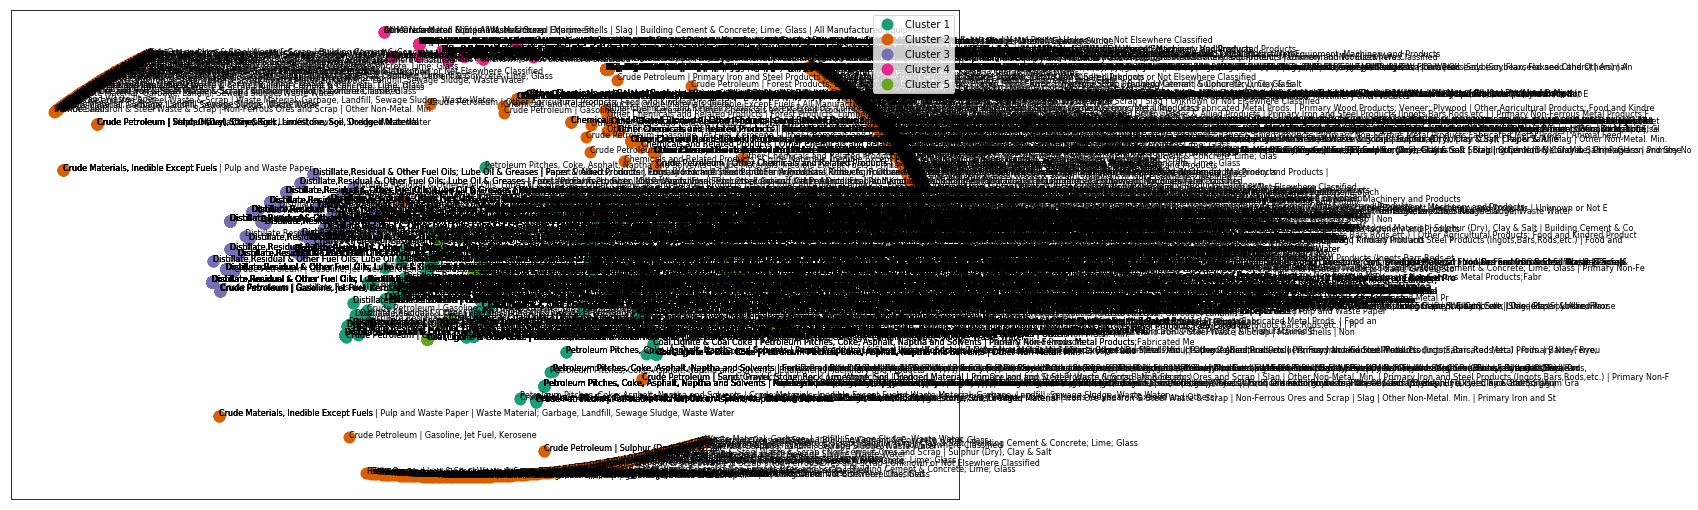

In [104]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=commodities_list)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

plt.show() #show the plot

In [106]:
#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)

In [61]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [62]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=commodities_list)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
# fig, ax = plt.subplots(figsize=(14,6)) #set plot size
# ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

fig, ax = plt.subplots(figsize=(20,10)) #set plot size

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

In [64]:
#uncomment the below to export to html
html = mpld3.fig_to_html(fig)
Html_file= open("commodity_clusters.html","w")
Html_file.write(html)
Html_file.close

<function TextIOWrapper.close>

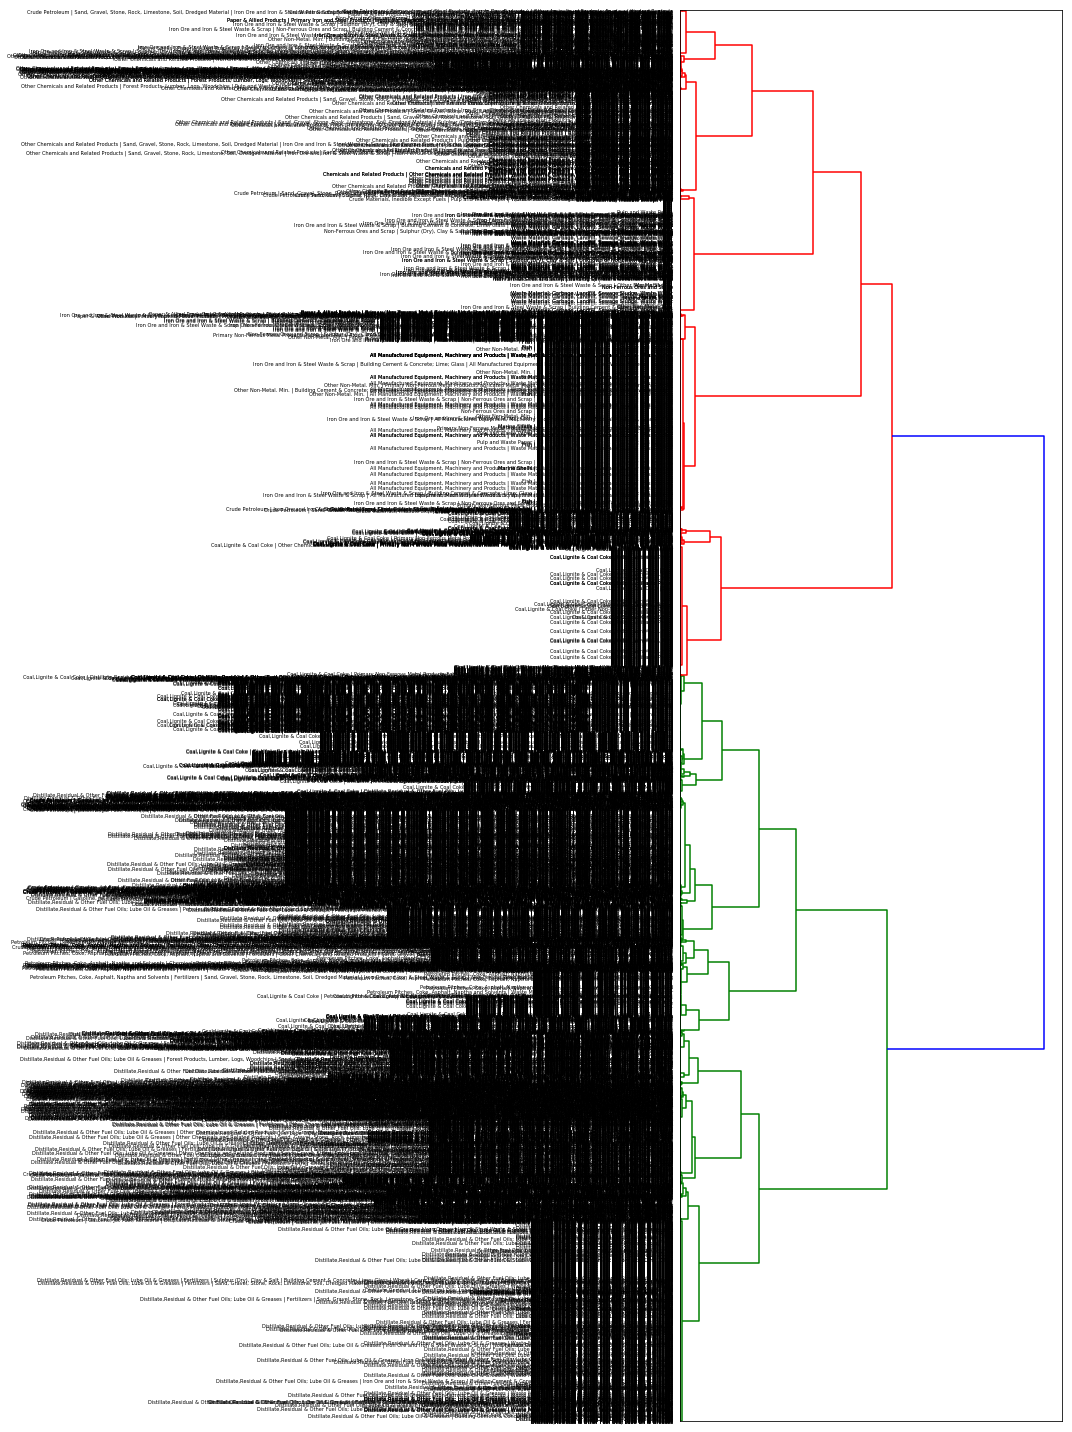

In [81]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=commodities_list);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters